In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle
from tqdm.notebook import tqdm

In [2]:
user_results = pickle.load(open('checkpoint_file.pkl', 'rb'))

In [3]:
def build_post_graph(user_results):
    # Collect all posts
    all_posts = []
    post_id_counter = 0
    post_to_idx = {}
    idx_to_post = {}
    
    for user_id, results in user_results.items():
        for post in results['post_details']:
            # Create a unique ID for each post
            post_idx = post_id_counter
            post_id_counter += 1
            
            # Store mapping
            post_key = (user_id, post.get('post_id', post_id_counter))
            post_to_idx[post_key] = post_idx
            idx_to_post[post_idx] = post_key
            
            # Store post with index
            all_posts.append({
                'user_id': user_id,
                'post_id': post.get('post_id', str(post_id_counter)),
                'post_idx': post_idx,
                'text': post.get('text', ''),
                'timestamp': post.get('timestamp', None),
                'subreddit': post.get('subreddit', None),
                'is_fake_news': post.get('is_fake_news', False),
                'fake_news_score': post.get('fake_news_score', 0)
            })
    
    # Create DataFrame
    posts_df = pd.DataFrame(all_posts)
    
    if len(posts_df) == 0:
        print("No posts found for analysis")
        return None, None, None, None, None
    
    print(f"Building graph with {len(posts_df)} posts")
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add post nodes
    for _, post in posts_df.iterrows():
        G.add_node(post['post_idx'], 
                   user_id=post['user_id'],
                   post_id=post['post_id'],
                   subreddit=post['subreddit'],
                   is_fake_news=post['is_fake_news'],
                   fake_news_score=post['fake_news_score'])
    
    # Add edges
    edges = []
    edge_weights = []
    
    # Connect posts from same user
    user_posts = posts_df.groupby('user_id')['post_idx'].apply(list).to_dict()
    
    for user_id, post_indices in tqdm(user_posts.items(), desc="Adding user edges"):
        if len(post_indices) < 2:
            continue
            
        for i in range(len(post_indices)):
            for j in range(i+1, len(post_indices)):
                edges.append((post_indices[i], post_indices[j]))
                edge_weights.append(1.0)  # Same-user connection weight
    
    # Connect posts from same subreddit
    subreddit_posts = posts_df.groupby('subreddit')['post_idx'].apply(list).to_dict()
    
    for subreddit, post_indices in tqdm(subreddit_posts.items(), desc="Adding subreddit edges"):
        if subreddit is None or len(post_indices) < 2:
            continue
            
        # Sample connections if too many posts in a subreddit
        if len(post_indices) > 100:
            import random
            num_connections = min(1000, len(post_indices) * 3)
            connections = set()
            
            for _ in range(num_connections):
                i, j = random.sample(range(len(post_indices)), 2)
                if i != j:
                    connections.add((min(i, j), max(i, j)))
            
            for i, j in connections:
                edges.append((post_indices[i], post_indices[j]))
                edge_weights.append(0.5)  # Same-subreddit connection weight
        else:
            # Connect all posts in smaller subreddits
            for i in range(len(post_indices)):
                for j in range(i+1, len(post_indices)):
                    edges.append((post_indices[i], post_indices[j]))
                    edge_weights.append(0.5)  # Same-subreddit connection weight
    
    # Add edges to graph
    for i, (u, v) in enumerate(edges):
        G.add_edge(u, v, weight=edge_weights[i])
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Create PyTorch Geometric Data object
    if not edges:
        print("No edges created. Cannot build graph.")
        return None, None, None, None, None
    
    edge_index = torch.tensor(edges).t().contiguous()
    edge_weights_tensor = torch.tensor(edge_weights, dtype=torch.float)
    
    # Get all unique subreddits
    subreddits = posts_df['subreddit'].dropna().unique().tolist()
    subreddit_to_idx = {sub: idx for idx, sub in enumerate(subreddits)}
    
    # Create simple node features
    node_features = []
    
    for node in range(len(posts_df)):
        post = posts_df[posts_df['post_idx'] == node]
        
        if len(post) == 0:
            features = [0, 0, 0, 0]
        else:
            features = [
                float(post['is_fake_news'].values[0]),             # Is fake news
                float(post['fake_news_score'].values[0]),          # Fake news score
                float(1.0 if post['subreddit'].values[0] else 0.0),# Has subreddit
                float(1.0 if post['timestamp'].values[0] else 0.0) # Has timestamp
            ]
        
        node_features.append(features)
    
    # Convert to tensor
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights_tensor)
    
    return data, G, post_to_idx, idx_to_post, posts_df

In [4]:
graph_data, G, post_to_idx, idx_to_post, posts_df = build_post_graph(user_results)

Building graph with 5536 posts


Adding user edges:   0%|          | 0/50 [00:00<?, ?it/s]

Adding subreddit edges:   0%|          | 0/26 [00:00<?, ?it/s]

Graph built with 5536 nodes and 323559 edges


In [26]:
class GCNEmbedder(nn.Module):
    """
    GCN model for learning post embeddings without the problematic clustering head
    """
    def __init__(self, input_dim, hidden_dim=64, embedding_dim=32, dropout_rate=0.3):
        super().__init__()
        # GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, embedding_dim)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, edge_index, edge_attr=None):
        # First GCN layer
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Third GCN layer
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        embeddings = self.bn3(x)
        embeddings = F.relu(embeddings)
        
        return embeddings

In [27]:
def train_model(data, epochs=50):
    model = GCNEmbedder(input_dim=data.x.size(1))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Using structure-based loss (connected nodes should have similar embeddings)
    def loss_fn(embeddings, edge_index):
        src, dst = edge_index
        edge_sim = F.cosine_similarity(embeddings[src], embeddings[dst])
        return -torch.mean(edge_sim)  # We want to maximize similarity
    
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        embeddings = model(data.x, data.edge_index, data.edge_attr)
        loss = loss_fn(embeddings, data.edge_index)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
    
    # Plot loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    return model

Epoch 0: Loss = -0.9221
Epoch 10: Loss = -0.9826
Epoch 20: Loss = -0.9890
Epoch 30: Loss = -0.9897
Epoch 40: Loss = -0.9909


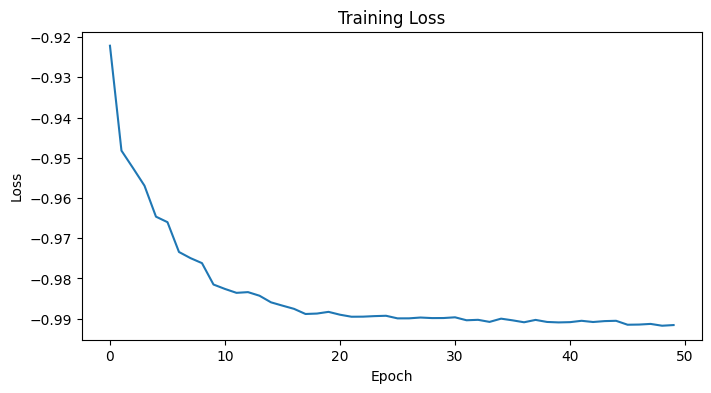

In [28]:
model = train_model(graph_data)

In [29]:
def cluster_posts(model, data, posts_df, num_clusters=5):
    # Get embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index, data.edge_attr)

    # Convert to numpy for K-means
    embeddings_np = embeddings.numpy()

    # Apply K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(embeddings_np)

    # Add cluster assignments to DataFrame
    posts_df['narrative_cluster'] = cluster_assignments

    # Visualize with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=cluster_assignments,
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Cluster')
    plt.title('Post Embeddings Visualization')
    plt.show()

    return posts_df, kmeans.cluster_centers_



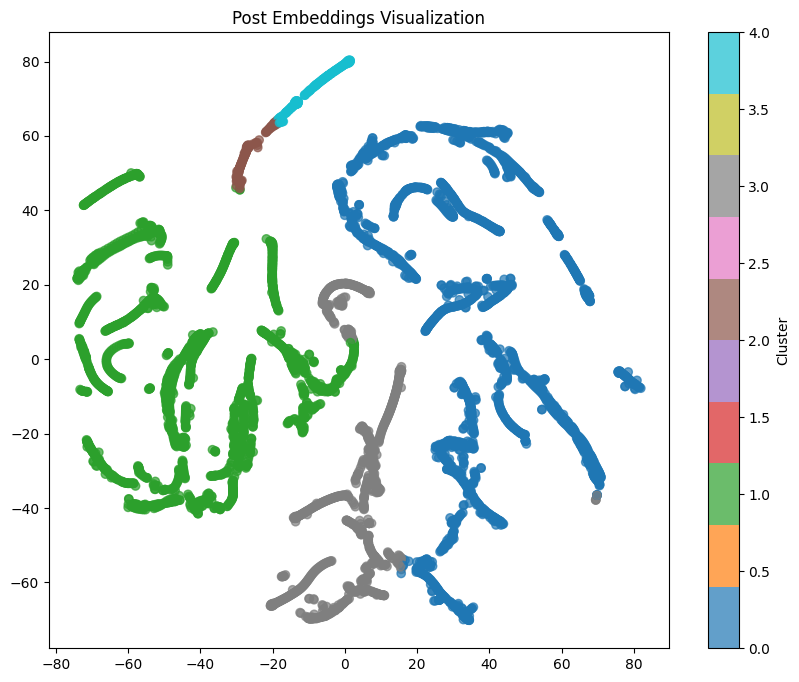

In [30]:
posts_with_clusters, cluster_centers = cluster_posts(model, graph_data, posts_df)

In [31]:
def analyze_clusters(posts_df):
    # Count posts per cluster
    cluster_counts = posts_df['narrative_cluster'].value_counts().sort_index()
    print("\nPosts per narrative cluster:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} posts")

    # Fake news ratio by cluster
    fake_by_cluster = posts_df.groupby('narrative_cluster')['is_fake_news'].mean()
    print("\nFake news ratio by cluster:")
    for cluster, ratio in fake_by_cluster.items():
        print(f"Cluster {cluster}: {ratio:.2f} fake news ratio")

    # Top subreddits by cluster
    print("\nTop subreddits by cluster:")
    for cluster in sorted(posts_df['narrative_cluster'].unique()):
        cluster_posts = posts_df[posts_df['narrative_cluster'] == cluster]
        subreddit_counts = cluster_posts['subreddit'].value_counts().head(3)

        print(f"Cluster {cluster} ({len(cluster_posts)} posts):")
        for subreddit, count in subreddit_counts.items():
            if subreddit:
                percentage = (count / len(cluster_posts)) * 100
                print(f"  r/{subreddit}: {count} posts ({percentage:.1f}%)")


In [32]:
analyze_clusters(posts_with_clusters)


Posts per narrative cluster:
Cluster 0: 2257 posts
Cluster 1: 2076 posts
Cluster 2: 111 posts
Cluster 3: 946 posts
Cluster 4: 146 posts

Fake news ratio by cluster:
Cluster 0: 0.31 fake news ratio
Cluster 1: 0.42 fake news ratio
Cluster 2: 0.54 fake news ratio
Cluster 3: 0.38 fake news ratio
Cluster 4: 0.58 fake news ratio

Top subreddits by cluster:
Cluster 0 (2257 posts):
  r/r/politics: 1673 posts (74.1%)
  r/r/Conservative: 226 posts (10.0%)
  r/r/CoronavirusUK: 120 posts (5.3%)
Cluster 1 (2076 posts):
  r/r/politics: 1178 posts (56.7%)
  r/r/Conservative: 445 posts (21.4%)
  r/r/NoNewNormal: 198 posts (9.5%)
Cluster 2 (111 posts):
  r/r/politics: 90 posts (81.1%)
  r/r/JoeBiden: 13 posts (11.7%)
  r/r/vaxxhappened: 4 posts (3.6%)
Cluster 3 (946 posts):
  r/r/politics: 538 posts (56.9%)
  r/r/Conservative: 135 posts (14.3%)
  r/r/JoeBiden: 131 posts (13.8%)
Cluster 4 (146 posts):
  r/r/politics: 135 posts (92.5%)
  r/r/uspolitics: 7 posts (4.8%)
  r/r/Conservative: 3 posts (2.1%)


In [33]:
with open('posts_with_clusters.pkl', 'wb') as f:
    pickle.dump(posts_with_clusters, f)

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [13]:
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [34]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load model and tokenizer
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_llm = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config
)
tokenizer_llm = AutoTokenizer.from_pretrained(model_name)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
def analyze_narrative_clusters_with_llm(cluster_df, model, tokenizer):
    cluster_summaries = {}
    
    for cluster_id in sorted(cluster_df['narrative_cluster'].unique()):
        # Get posts for this cluster
        cluster_posts = cluster_df[cluster_df['narrative_cluster'] == cluster_id]
        
        if len(cluster_posts) == 0:
            continue
            
        # Get post texts
        post_texts = cluster_posts['text'].tolist()
        
        print(f"\nGenerating summary for Narrative Cluster {cluster_id} ({len(post_texts)} posts)...")
        
        # Get LLM summary
        summary = summarize_narrative_with_llm(post_texts, model, tokenizer)
        
        # Store summary
        cluster_summaries[cluster_id] = {
            'summary': summary,
            'num_posts': len(post_texts),
            'top_subreddits': cluster_posts['subreddit'].value_counts().head(3).to_dict()
        }
        
        # Print summary
        print(f"Summary for Narrative Cluster {cluster_id}:")
        print(summary)
        print(f"Top subreddits: {', '.join(cluster_summaries[cluster_id]['top_subreddits'].keys())}")
        print("-" * 50)
    
    return cluster_summaries

In [36]:
def summarize_narrative_with_llm(posts, model, tokenizer, max_sample=500, max_context_tokens=128000):
    # Set padding token if needed
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Sample posts if there are too many
    if len(posts) > max_sample:
        import random
        sampled_posts = random.sample(posts, max_sample)
    else:
        sampled_posts = posts
    
    # Truncate very long posts
    processed_posts = [post[:1000] + "..." if len(post) > 1000 else post for post in sampled_posts]
    
    # Create prompt
    base_prompt = """You are an expert at identifying narrative themes in social media content.
    
Below are several posts that have been identified as part of the same narrative cluster. 
Please provide:
1. A concise one-sentence description of the main narrative or theme
2. Three key points or claims that seem to be repeated across these posts
3. The likely factual accuracy of this narrative based on your knowledge

Posts:
"""
    end_prompt = "\n\nYour summary (keep it concise):"
    
    # Calculate token budget
    base_prompt_tokens = len(tokenizer.encode(base_prompt))
    end_prompt_tokens = len(tokenizer.encode(end_prompt))
    reserved_tokens = 300  # Reserve tokens for the model's response
    max_post_tokens = max_context_tokens - base_prompt_tokens - end_prompt_tokens - reserved_tokens
    
    # Calculate token counts for each post
    post_tokens = [(post, len(tokenizer.encode(post))) for post in processed_posts]
    post_tokens.sort(key=lambda x: x[1])  # Sort by token length (shortest first)
    
    # Select posts to fit within token budget
    selected_posts = []
    current_tokens = 0
    
    for post, token_count in post_tokens:
        prefix_tokens = len(tokenizer.encode(f"Post {len(selected_posts)+1}: ")) - 1
        if current_tokens + token_count + prefix_tokens < max_post_tokens:
            selected_posts.append(post)
            current_tokens += token_count + prefix_tokens
        else:
            break
    
    print(f"Summarizing {len(selected_posts)} posts out of {len(posts)} total posts in cluster")
    
    # Create the full prompt
    post_text = "\n".join([f"Post {i+1}: {text}" for i, text in enumerate(selected_posts)])
    full_prompt = base_prompt + post_text + end_prompt
    
    # Tokenize input
    inputs = tokenizer(full_prompt, return_tensors="pt", padding=True, truncation=True, 
                      max_length=max_context_tokens)
    
    # Move to correct device
    device = model.device if hasattr(model, 'device') else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate summary
    print("Generating summary...")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.7,
            do_sample=True,
            min_new_tokens=100,
            no_repeat_ngram_size=3,
            top_p=0.9
        )
    
    # Extract generated text
    input_length = inputs['input_ids'].shape[1]
    summary = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True).strip()
    
    # Fallback if needed
    if not summary:
        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if end_prompt in full_output:
            summary = full_output.split(end_prompt, 1)[1].strip()
        else:
            summary = "Error: Could not extract summary from model output."
    
    return summary

In [37]:
cluster_summaries=analyze_narrative_clusters_with_llm(posts_df, model_llm, tokenizer_llm)


Generating summary for Narrative Cluster 0 (2257 posts)...
Summarizing 500 posts out of 2257 total posts in cluster
Generating summary...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Summary for Narrative Cluster 0:
The main narrative theme is the struggle for truth and accountability in the face a misinformation and propaganda. The repeated claims are:

1. The importance of fact-checking and critical thinking in a post-truth world.
2. The dangers of misinformation and disinformation campaigns, particularly those funded by Russia and other authoritarian regimes.
3. Concerns about the erosion of civil liberties and the rule of law, as well the normalization of extremist ideologies and behaviors.

The likely factual correctness of this theme is: **Highly likely**. The posts are based on real events, policies, and opinions from reputable sources, and many of the claims can be verified through fact-checkers and academic research.

Note: The theme is not necessarily a unified narrative, but more of a collection of related claims and concerns that are repeated throughout the posts. The tone is often critical and sarcastic, reflecting the frustration and outrage of many p

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating summary...


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Summary for Narrative Cluster 1:
1. Main narrative theme: The struggle between free speech, fact-based information, truth, and censorship, with a focus on narratives around the COVID-019 pandemic, vaccine passports, and government control.
2. Key points or repeated claims:
- The media is often biased and controlled by powerful interests.
- Vaccines and vaccine passports are a means to control and manipulate populations.
- The COVID-1919 pandemic is a tool for governments to exert control and impose authoritarian measures.
- There is concern about the safety, effectiveness, and long-term effects of vaccines.
- Governments and pharmaceutical companies are prioritizing profits over public health.
- People are waking up to these issues and questioning the narratives they've accepted.
3. Factual accuracy: The narrative appears to be influenced by misinformation and conspiracy theories, often relying on unverified sources and unproven claims. Many of the points made are based on hearsay, spe

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Summary for Narrative Cluster 2:
1. Main narrative or them: 
The narrative revolves around the alleged misconduct and malfeasance of President Trump and his administration, focusing on their handling of the COVID-019 pandemic, election interference, and various forms of corruption.

2. Key points or repeated claims:
* Trump's COVID- 19 response was catastrophic and involved a racketering scam, with hospitals seizing masks, and the f eds stealing supplies.
* Trump and supporters engaged in various forms o f election interference including recruiting third-party candidates, spreading false information, and intimidating voters.
* The administration was accused of corruption, including using taxpayer funds personally, and acquiring authority to control business contracts.

3. Factual accuracy: 
While some claims are accurate, many appear to be exaggerated, distorted, or unsubstantiated. The posts lack credible sources to support some of the assertions, and some may be propaganda or disinfo

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Summary for Narrative Cluster 3:
The main narrative theme is about the COVID-19 pandemic, its impact on society, and politicians' responses to it. Key points repeated across the posts include:

1. The importance of mask-wearing and social distancing to prevent the spread of COVID- 19.
2. Criticism of politicians, particularly Trump, for their handling of the crisis.
3. Discussion of the economic and social consequences of the lockdown measures.
4. Concerns about the potential long-term effects of the vaccine passports.
5. Debates about the role of the government and the private sector in addressing the pandemic.

The factual accuracy is difficult to determine due to the varying quality of sources and the subjective nature of some claims. However, the posts do reflect the widespread concern and debate about the pandemic and its impact.  -_summary_-

**Main Narrative Theme:** The COVID--19 Pandemic and its Impact on Society

**Key Points Repeated Across Posts:**

1. Importance of mask we

In [38]:
with open('cluster_summaries.pkl', 'wb') as f:
     pickle.dump(cluster_summaries, f)

In [39]:
cluster_summaries

{0: {'summary': "The main narrative theme is the struggle for truth and accountability in the face a misinformation and propaganda. The repeated claims are:\n\n1. The importance of fact-checking and critical thinking in a post-truth world.\n2. The dangers of misinformation and disinformation campaigns, particularly those funded by Russia and other authoritarian regimes.\n3. Concerns about the erosion of civil liberties and the rule of law, as well the normalization of extremist ideologies and behaviors.\n\nThe likely factual correctness of this theme is: **Highly likely**. The posts are based on real events, policies, and opinions from reputable sources, and many of the claims can be verified through fact-checkers and academic research.\n\nNote: The theme is not necessarily a unified narrative, but more of a collection of related claims and concerns that are repeated throughout the posts. The tone is often critical and sarcastic, reflecting the frustration and outrage of many people in